In [15]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from src.data import get_data
from src.util import common

import pickle

p=print

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
SYM='ETH'
Ty=1
Tx=72
MAX_LAG=72

In [17]:
"""
Import Data.
"""
def load_preprocessed_data(sym, Tx, Ty, max_lag):
    X_train=pd.read_csv('../data/processed/X_train_{}_tx{}_ty{}_flag{}.csv'.format(SYM, Tx, Ty, MAX_LAG))
    y_train=pd.read_csv('../data/processed/y_train_{}_tx{}_ty{}_flag{}.csv'.format(SYM, Tx, Ty, MAX_LAG))
    X_test=pd.read_csv  ('../data/processed/X_test_{}_tx{}_ty{}_flag{}.csv'.format(SYM, Tx, Ty, MAX_LAG))
    y_test=pd.read_csv  ('../data/processed/y_test_{}_tx{}_ty{}_flag{}.csv'.format(SYM, Tx, Ty, MAX_LAG))
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = load_preprocessed_data(SYM, Tx, Ty, MAX_LAG)

In [18]:
N_FEATURES=int(X_train.columns.values.size / Tx)

In [19]:
from xgboost import XGBRegressor

parameters = {
  'objective':'reg:linear',
  'learning_rate': .07, 
  'max_depth': 10,
  'min_child_weight': 4,
  'silent': 1,
  'subsample': 0.7,
  'colsample_bytree': 0.7,
  'n_estimators': 400,
  'early_stopping_rounds':50
}

xgb_reg=XGBRegressor(**parameters)

In [20]:
from sklearn.model_selection import GridSearchCV

grid_params = {
    'max_depth':[3,4,5,6]
}
xgb_grid = GridSearchCV(
    xgb_reg,
    grid_params,
    scoring='neg_mean_absolute_error',
    cv = 2,
    n_jobs = -1,
    verbose=True
)

In [21]:
xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  8.8min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, early_stopping_rounds=50, gamma=0,
       learning_rate=0.07, max_delta_step=0, max_depth=10,
       min_child_weight=4, missing=None, n_estimators=400, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=True)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

xgb_predict=xgb_grid.predict(X_test)

p(mean_absolute_error(xgb_predict, y_test))
p(mean_squared_error(xgb_predict, y_test))

print(xgb_grid.best_params_)

0.7368572514682603
1.2619658550546982
{'max_depth': 3}


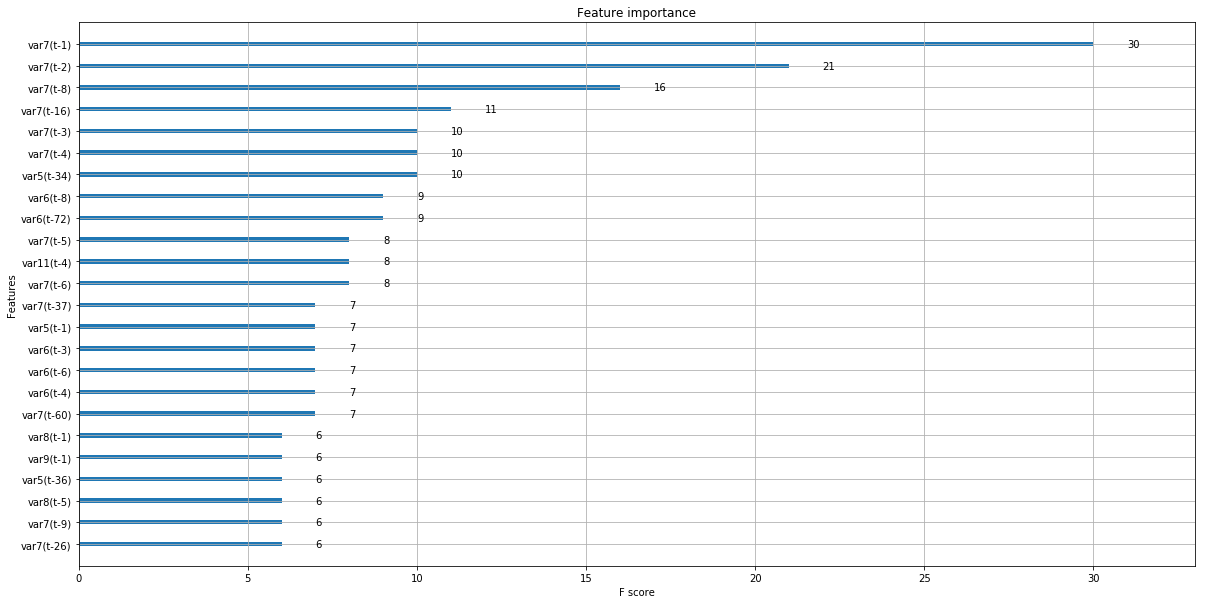

In [10]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(20, 10))
plot_importance(ax=ax, booster=xgb_grid.best_estimator_, max_num_features=24)

In [ ]:
xgb_lc = XGBRegressorgressorgressor(**paramters).set_params(**xgb_grid.best_params_)

In [12]:
def calc_xgboost_learning_curve(model, step, X_train, X_test, y_train, y_test):
    scorestrain=[]
    scorescv=[]
    iterations=[]

    for i in range(step,len(X_train),step) :                
        print(i)
        model.fit(X_train[:i], y_train[:i], 
                    early_stopping_rounds=50, 
                    eval_metric="mae",
                    eval_set=[(X_test, y_test)]
        )
        scorestrain.append(mean_absolute_error(y_train[:i], xgb_reg.predict(X_train[:i], ntree_limit=xgb_reg.best_iteration)))
        scorescv.append(mean_absolute_error(y_test,xgb_reg.predict(X_test,ntree_limit=xgb_reg.best_iteration)))
        iterations.append(i)
    return iterations, scorestrain, scorescv
iterations, scorestrain, scorescv = calc_xgboost_learning_curve(xgb_lc, 500, X_train, X_test, y_train, y_test)

500
[0]	validation_0-mae:0.576948
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.549915
[2]	validation_0-mae:0.529771
[3]	validation_0-mae:0.531394
[4]	validation_0-mae:0.502319
[5]	validation_0-mae:0.489014
[6]	validation_0-mae:0.48802
[7]	validation_0-mae:0.490645
[8]	validation_0-mae:0.478092
[9]	validation_0-mae:0.449661
[10]	validation_0-mae:0.427174
[11]	validation_0-mae:0.418114
[12]	validation_0-mae:0.407604
[13]	validation_0-mae:0.387928
[14]	validation_0-mae:0.374982
[15]	validation_0-mae:0.36893
[16]	validation_0-mae:0.354513
[17]	validation_0-mae:0.35711
[18]	validation_0-mae:0.34957
[19]	validation_0-mae:0.346256
[20]	validation_0-mae:0.343797
[21]	validation_0-mae:0.336142
[22]	validation_0-mae:0.334247
[23]	validation_0-mae:0.331342
[24]	validation_0-mae:0.330476
[25]	validation_0-mae:0.328366
[26]	validation_0-mae:0.328087
[27]	validation_0-mae:0.327806
[28]	validation_0-mae:0.327398
[29]	validation_0-mae:0.327664
[30]	validation_

[8]	validation_0-mae:0.433083
[9]	validation_0-mae:0.431352
[10]	validation_0-mae:0.431681
[11]	validation_0-mae:0.429489
[12]	validation_0-mae:0.428498
[13]	validation_0-mae:0.468074
[14]	validation_0-mae:0.465557
[15]	validation_0-mae:0.467929
[16]	validation_0-mae:0.503687
[17]	validation_0-mae:0.508116
[18]	validation_0-mae:0.530641
[19]	validation_0-mae:0.522753
[20]	validation_0-mae:0.572831
[21]	validation_0-mae:0.59761
[22]	validation_0-mae:0.575121
[23]	validation_0-mae:0.664707
[24]	validation_0-mae:0.757933
[25]	validation_0-mae:0.752647
[26]	validation_0-mae:0.803138
[27]	validation_0-mae:0.849469
[28]	validation_0-mae:0.885669
[29]	validation_0-mae:0.890227
[30]	validation_0-mae:0.894069
[31]	validation_0-mae:0.89651
[32]	validation_0-mae:0.950263
[33]	validation_0-mae:0.958763
[34]	validation_0-mae:0.963044
[35]	validation_0-mae:0.992965
[36]	validation_0-mae:0.995098
[37]	validation_0-mae:1.0145
[38]	validation_0-mae:0.981131
[39]	validation_0-mae:0.921556
[40]	validatio

[33]	validation_0-mae:1.67891
[34]	validation_0-mae:1.78439
[35]	validation_0-mae:1.77748
[36]	validation_0-mae:1.78047
[37]	validation_0-mae:1.78186
[38]	validation_0-mae:1.77351
[39]	validation_0-mae:1.76783
[40]	validation_0-mae:1.76957
[41]	validation_0-mae:1.77105
[42]	validation_0-mae:1.73594
[43]	validation_0-mae:1.73748
[44]	validation_0-mae:1.72665
[45]	validation_0-mae:1.84256
[46]	validation_0-mae:1.84386
[47]	validation_0-mae:1.7617
[48]	validation_0-mae:1.77133
[49]	validation_0-mae:1.88365
[50]	validation_0-mae:1.88499
[51]	validation_0-mae:2.00811
[52]	validation_0-mae:2.00066
Stopping. Best iteration:
[2]	validation_0-mae:0.365329

5000
[0]	validation_0-mae:0.544498
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.422962
[2]	validation_0-mae:0.343135
[3]	validation_0-mae:0.337715
[4]	validation_0-mae:0.338115
[5]	validation_0-mae:0.342411
[6]	validation_0-mae:0.348267
[7]	validation_0-mae:0.354291
[8]	validation_0-mae:0.360939
[9]	v

[60]	validation_0-mae:0.350501
[61]	validation_0-mae:0.350879
[62]	validation_0-mae:0.351572
[63]	validation_0-mae:0.351573
[64]	validation_0-mae:0.375097
[65]	validation_0-mae:0.42069
[66]	validation_0-mae:0.421176
[67]	validation_0-mae:0.420827
[68]	validation_0-mae:0.421187
[69]	validation_0-mae:0.42674
[70]	validation_0-mae:0.427177
[71]	validation_0-mae:0.430679
Stopping. Best iteration:
[21]	validation_0-mae:0.332467

7000
[0]	validation_0-mae:0.548081
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.525174
[2]	validation_0-mae:0.50306
[3]	validation_0-mae:0.483359
[4]	validation_0-mae:0.461616
[5]	validation_0-mae:0.446053
[6]	validation_0-mae:0.432502
[7]	validation_0-mae:0.419782
[8]	validation_0-mae:0.409126
[9]	validation_0-mae:0.39979
[10]	validation_0-mae:0.39155
[11]	validation_0-mae:0.38426
[12]	validation_0-mae:0.37797
[13]	validation_0-mae:0.37284
[14]	validation_0-mae:0.367466
[15]	validation_0-mae:0.363462
[16]	validation_0-mae:0

[72]	validation_0-mae:0.331513
[73]	validation_0-mae:0.331594
[74]	validation_0-mae:0.331627
[75]	validation_0-mae:0.331675
[76]	validation_0-mae:0.3317
[77]	validation_0-mae:0.33172
[78]	validation_0-mae:0.331974
[79]	validation_0-mae:0.33181
[80]	validation_0-mae:0.332324
[81]	validation_0-mae:0.33223
[82]	validation_0-mae:0.332149
[83]	validation_0-mae:0.332071
[84]	validation_0-mae:0.33205
[85]	validation_0-mae:0.332229
[86]	validation_0-mae:0.332259
[87]	validation_0-mae:0.332541
[88]	validation_0-mae:0.332635
[89]	validation_0-mae:0.332654
[90]	validation_0-mae:0.332621
[91]	validation_0-mae:0.332711
[92]	validation_0-mae:0.333086
[93]	validation_0-mae:0.333042
[94]	validation_0-mae:0.33281
[95]	validation_0-mae:0.332774
[96]	validation_0-mae:0.332862
[97]	validation_0-mae:0.332742
Stopping. Best iteration:
[47]	validation_0-mae:0.331396

8500
[0]	validation_0-mae:0.548294
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.524334
[2]	validation

Stopping. Best iteration:
[54]	validation_0-mae:0.331501

9500
[0]	validation_0-mae:0.548478
Will train until validation_0-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:0.524966
[2]	validation_0-mae:0.504216
[3]	validation_0-mae:0.485242
[4]	validation_0-mae:0.468805
[5]	validation_0-mae:0.453039
[6]	validation_0-mae:0.438876
[7]	validation_0-mae:0.426316
[8]	validation_0-mae:0.41437
[9]	validation_0-mae:0.404401
[10]	validation_0-mae:0.395719
[11]	validation_0-mae:0.388044
[12]	validation_0-mae:0.38157
[13]	validation_0-mae:0.3755
[14]	validation_0-mae:0.370402
[15]	validation_0-mae:0.366142
[16]	validation_0-mae:0.36223
[17]	validation_0-mae:0.358843
[18]	validation_0-mae:0.355842
[19]	validation_0-mae:0.352879
[20]	validation_0-mae:0.350243
[21]	validation_0-mae:0.347603
[22]	validation_0-mae:0.345527
[23]	validation_0-mae:0.343904
[24]	validation_0-mae:0.34252
[25]	validation_0-mae:0.341105
[26]	validation_0-mae:0.339891
[27]	validation_0-mae:0.338982
[28]	validation_0-mae

[6]	validation_0-mae:0.434966
[7]	validation_0-mae:0.422514
[8]	validation_0-mae:0.411537
[9]	validation_0-mae:0.401175
[10]	validation_0-mae:0.392117
[11]	validation_0-mae:0.38443
[12]	validation_0-mae:0.377366
[13]	validation_0-mae:0.371225
[14]	validation_0-mae:0.366355
[15]	validation_0-mae:0.361279
[16]	validation_0-mae:0.35752
[17]	validation_0-mae:0.353942
[18]	validation_0-mae:0.351011
[19]	validation_0-mae:0.348494
[20]	validation_0-mae:0.346102
[21]	validation_0-mae:0.343578
[22]	validation_0-mae:0.341977
[23]	validation_0-mae:0.340335
[24]	validation_0-mae:0.338854
[25]	validation_0-mae:0.337698
[26]	validation_0-mae:0.336508
[27]	validation_0-mae:0.335251
[28]	validation_0-mae:0.33446
[29]	validation_0-mae:0.333839
[30]	validation_0-mae:0.333145
[31]	validation_0-mae:0.332519
[32]	validation_0-mae:0.331924
[33]	validation_0-mae:0.331383
[34]	validation_0-mae:0.331106
[35]	validation_0-mae:0.330861
[36]	validation_0-mae:0.330448
[37]	validation_0-mae:0.330209
[38]	validation

[26]	validation_0-mae:0.337
[27]	validation_0-mae:0.336057
[28]	validation_0-mae:0.334963
[29]	validation_0-mae:0.334128
[30]	validation_0-mae:0.333306
[31]	validation_0-mae:0.332625
[32]	validation_0-mae:0.332043
[33]	validation_0-mae:0.331529
[34]	validation_0-mae:0.331111
[35]	validation_0-mae:0.330778
[36]	validation_0-mae:0.330492
[37]	validation_0-mae:0.329994
[38]	validation_0-mae:0.329913
[39]	validation_0-mae:0.329625
[40]	validation_0-mae:0.329344
[41]	validation_0-mae:0.329094
[42]	validation_0-mae:0.329245
[43]	validation_0-mae:0.329498
[44]	validation_0-mae:0.329406
[45]	validation_0-mae:0.329147
[46]	validation_0-mae:0.32903
[47]	validation_0-mae:0.328896
[48]	validation_0-mae:0.328857
[49]	validation_0-mae:0.328785
[50]	validation_0-mae:0.328677
[51]	validation_0-mae:0.328623
[52]	validation_0-mae:0.32876
[53]	validation_0-mae:0.328708
[54]	validation_0-mae:0.328874
[55]	validation_0-mae:0.328873
[56]	validation_0-mae:0.328819
[57]	validation_0-mae:0.328846
[58]	validati

[30]	validation_0-mae:0.333453
[31]	validation_0-mae:0.332871
[32]	validation_0-mae:0.332271
[33]	validation_0-mae:0.331718
[34]	validation_0-mae:0.331323
[35]	validation_0-mae:0.331037
[36]	validation_0-mae:0.33072
[37]	validation_0-mae:0.330305
[38]	validation_0-mae:0.330027
[39]	validation_0-mae:0.329886
[40]	validation_0-mae:0.329667
[41]	validation_0-mae:0.329494
[42]	validation_0-mae:0.329413
[43]	validation_0-mae:0.329207
[44]	validation_0-mae:0.329205
[45]	validation_0-mae:0.328979
[46]	validation_0-mae:0.32877
[47]	validation_0-mae:0.328589
[48]	validation_0-mae:0.328593
[49]	validation_0-mae:0.328511
[50]	validation_0-mae:0.328665
[51]	validation_0-mae:0.328626
[52]	validation_0-mae:0.328574
[53]	validation_0-mae:0.328514
[54]	validation_0-mae:0.328458
[55]	validation_0-mae:0.328426
[56]	validation_0-mae:0.328493
[57]	validation_0-mae:0.328497
[58]	validation_0-mae:0.328481
[59]	validation_0-mae:0.328473
[60]	validation_0-mae:0.328495
[61]	validation_0-mae:0.328097
[62]	valid

[34]	validation_0-mae:0.330481
[35]	validation_0-mae:0.330092
[36]	validation_0-mae:0.329768
[37]	validation_0-mae:0.329576
[38]	validation_0-mae:0.32932
[39]	validation_0-mae:0.328674
[40]	validation_0-mae:0.328422
[41]	validation_0-mae:0.327905
[42]	validation_0-mae:0.327822
[43]	validation_0-mae:0.327684
[44]	validation_0-mae:0.327414
[45]	validation_0-mae:0.327285
[46]	validation_0-mae:0.327329
[47]	validation_0-mae:0.327233
[48]	validation_0-mae:0.32718
[49]	validation_0-mae:0.327183
[50]	validation_0-mae:0.327294
[51]	validation_0-mae:0.327369
[52]	validation_0-mae:0.327228
[53]	validation_0-mae:0.327175
[54]	validation_0-mae:0.327137
[55]	validation_0-mae:0.327107
[56]	validation_0-mae:0.326906
[57]	validation_0-mae:0.326819
[58]	validation_0-mae:0.326755
[59]	validation_0-mae:0.326722
[60]	validation_0-mae:0.326725
[61]	validation_0-mae:0.32674
[62]	validation_0-mae:0.326602
[63]	validation_0-mae:0.32672
[64]	validation_0-mae:0.326699
[65]	validation_0-mae:0.326686
[66]	validat

[56]	validation_0-mae:0.328524
[57]	validation_0-mae:0.32854
[58]	validation_0-mae:0.328661
[59]	validation_0-mae:0.328555
[60]	validation_0-mae:0.328575
[61]	validation_0-mae:0.328515
[62]	validation_0-mae:0.328415
[63]	validation_0-mae:0.328302
[64]	validation_0-mae:0.328441
[65]	validation_0-mae:0.328479
[66]	validation_0-mae:0.328486
[67]	validation_0-mae:0.328473
[68]	validation_0-mae:0.328506
[69]	validation_0-mae:0.3279
[70]	validation_0-mae:0.32791
[71]	validation_0-mae:0.327893
[72]	validation_0-mae:0.327798
[73]	validation_0-mae:0.327754
[74]	validation_0-mae:0.327797
[75]	validation_0-mae:0.327803
[76]	validation_0-mae:0.327767
[77]	validation_0-mae:0.327768
[78]	validation_0-mae:0.327789
[79]	validation_0-mae:0.327781
[80]	validation_0-mae:0.327665
[81]	validation_0-mae:0.327789
[82]	validation_0-mae:0.327799
[83]	validation_0-mae:0.327755
[84]	validation_0-mae:0.327835
[85]	validation_0-mae:0.328008
[86]	validation_0-mae:0.328008
[87]	validation_0-mae:0.328077
[88]	validat

## Model performs worse as BTC price spikes. Get's better afterwards. Test set is easier for model to predict than train set.

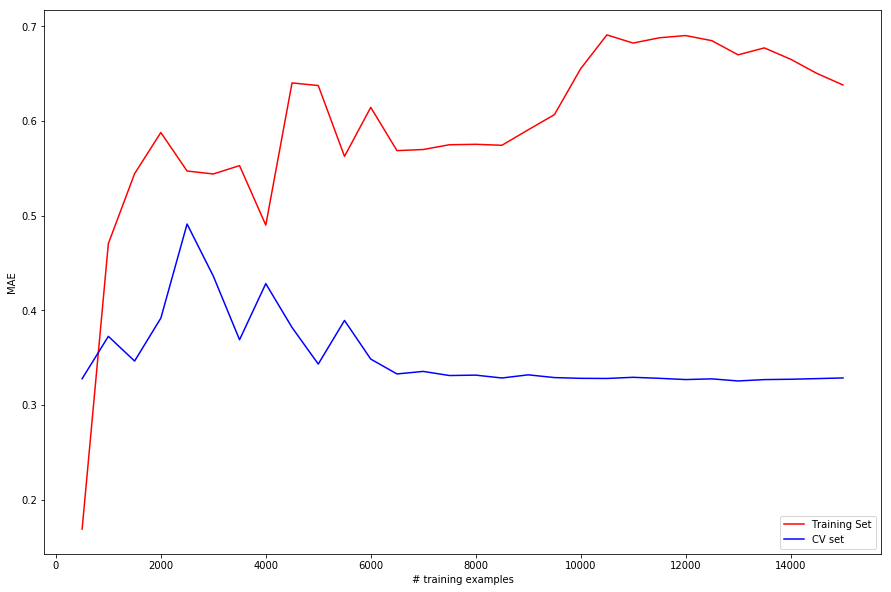

In [13]:
def plot_xgboost_learning_curve(iterations, scorestrain, scorescv):
    plt.figure(figsize=(15,10))
    plt.plot(iterations,scorestrain,'r')
    plt.plot(iterations,scorescv, 'b')
    plt.xlabel('# training examples')
    plt.ylabel('MAE')
    plt.legend(['Training Set','CV set'],loc='lower right')
plot_xgboost_learning_curve(iterations, scorestrain, scorescv)

In [23]:
# Save model
with open('../models/xgboost_{}_tx{}_ty{}_flag{}.pkl'.format(SYM, Tx, Ty, MAX_LAG), 'wb') as output_file:
    s = pickle.dump(xgb_grid.best_estimator_, output_file)